In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
from numpy import matmul
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import load_diabetes
import pandas as pd
from scipy.linalg import cholesky
from scipy.linalg import solve
from scipy.optimize import minimize
import time

In [2]:
# Developer notes
# 1) Cholesky decomposition produces NaNs (probably because K+I*s**2 is not pos semidef) causing solve to complain
# 2) Including gradient for likelihood made optimization much faster

class mintGP():
    """
    The implementation is based on Algorithm 2.1 of Gaussian Processes
    for Machine Learning (GPML) by Rasmussen and Williams.
    
    Takes 2D np-arrays
    """
    
    def __init__(self):
        pass
        
    def fit(self, X, Y):
        self.yscale = np.std(Y)
        self.Y = Y/self.yscale
        self.X = X
        self.n = np.shape(X)[0]
        # initialize with heuristics
        self.lengthscale = np.mean(pdist(X, metric='euclidean'))
        self.likelihood_variance =  1
        
        ###############################################################
        # Gradient descent on marginal likelihood with scipy L-BFGS-B #
        ###############################################################
        theta0 = np.array([self.lengthscale, self.likelihood_variance])
        bnds = ((1e-20, None), (1e-10, None))
        sol = minimize(self.neg_log_marg_like, theta0, args=(),
                       method='L-BFGS-B', bounds=bnds, jac=True) 
        self.lengthscale, self.likelihood_variance = sol.x
        self.marginal_likelihood = np.exp(-sol.fun)
        
        # for prediction:
        K,_ = self.K(X,X,self.lengthscale)
        self.L = cholesky( K + self.likelihood_variance*np.eye(self.n), lower=True)
        print(sol.x, theta0)
    
    ##########################
    # Likelihood computation #
    ##########################
    def neg_log_marg_like(self, theta):
        """
        Compute negative log marginal likelihood for hyperparameter optimization
        """
        jitter=0
        K, D = self.K(self.X ,self.X, theta[0])
        L = cholesky( K + (theta[1]+jitter)*np.eye(self.n), lower=True)
        self.L = L
        alpha = solve(L.T, solve(L,self.Y, lower=True) )
        logmarglike = \
        - 0.5*matmul(self.Y.T, alpha)[0,0]     \
        - np.sum( np.log( np.diag( L ) ) )   \
        - 0.5*self.n*np.log(2*np.pi)
        
        
        # compute gradients
        prefactor = matmul(alpha, alpha.T) - solve(L.T, solve(L, np.eye(self.n) ) )
        Kd_lengthscale = np.multiply( D/theta[0]**3, K)
        Kd_likelihood_variance = np.eye(self.n)
        logmarglike_grad = 0.5*np.array( [ np.trace( matmul(prefactor, Kd_lengthscale) ),
                                           np.trace( matmul(prefactor, Kd_likelihood_variance) )] )

        
        return -logmarglike, -logmarglike_grad
    
    def nlml_grad(self):
        """
        Return gradient of negative log marginal likelihood
        """
        return self.logmarglike_grad
    
    ######################
    # Kernel computation #
    ######################
    def K(self, X, Z, lengthscale):
        n1 = np.shape(X)[0]
        n2 = np.shape(Z)[0]
        n1sq = np.sum(np.square(X), 1)
        n2sq = np.sum(np.square(Z), 1)
        
        D = (np.ones([n2, 1])*n1sq).T + np.ones([n1, 1])*n2sq -2*matmul(X,Z.T)
        return np.exp(-D/(2*lengthscale**2)), D
    
    def scalarK(self, x, z, lengthscale):
        return( np.exp( np.linalg.norm(x - z)**2/(2*lengthscale**2) ) )
    
    ###########################
    # Predictive distribution #
    ###########################
    def predict(self, Xnew, predvar=False):
        alpha = solve(self.L.T, solve(self.L,self.Y*self.yscale ) )
        if predvar:
            m = np.shape(Xnew)[0]
            Knew_N,_ = self.K(Xnew, self.X, self.lengthscale)
            Knew_new = np.array( [self.scalarK(Xnew[i], Xnew[i], self.lengthscale) for i in range(m)] ).reshape([m,1])
            v = solve(self.L, Knew_N.T)
            return matmul(Knew_N, alpha), np.diag( Knew_new + self.likelihood_variance - matmul(v.T, v) ).reshape(m,1)
        else:
            Knew_N,_ = self.K(Xnew, self.X, self.lengthscale)
            return matmul(Knew_N, alpha)
    
    ###############################   
    # Gradient of predictive mean #
    ###############################
    def predictive_grad(self, Xnew):
        alpha = solve(self.L.T, solve(self.L, self.Y*self.yscale ) )
        Knew_N,_ = self.K(Xnew, self.X, self.lengthscale)
        
        return (-1/self.lengthscale**2)*matmul( np.tile(Xnew.T, self.n) - self.X.T, np.multiply(Knew_N.T, alpha) )

## 1D Toy example with missing data, gradient computation, likelihood surface plot


[ 1.30113801  0.10936404] [ 3.59901867  1.        ]
1.30113800545 0.109364039911
time to compute  0.05816292762756348


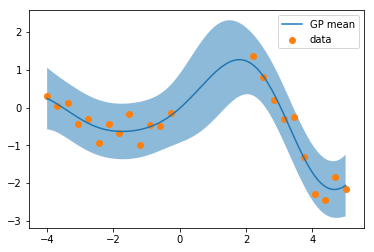

In [3]:
N = 30

Nt = 400
X = np.linspace(-4,5,N).reshape(N,1);
# We can pick out some values to illustrate how the uncertainty estimate behaves 
# it's interesting to see what happens to likelihood below 

ind = np.bool8([1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]); X = X[ ind ]; N=N-sum(~ind)
Xt = np.linspace(-4,5,Nt).reshape(Nt,1)

Y = np.sin(X)*np.exp(0.2*X) + np.random.randn(N,1)*0.3


t0 = time.time()


m = mintGP()
m.fit(X,Y)
print( m.lengthscale, m.likelihood_variance )

pred, var = m.predict(Xt,predvar=True)
t1 = time.time()
print('time to compute ',t1-t0)


fig, ax = plt.subplots()
ax.plot(Xt, pred, label="GP mean")
twostd = 2*np.sqrt(var)

ax.fill_between(Xt.ravel(), (pred-twostd).ravel(), (pred+twostd).ravel(), alpha=0.5)
ax.scatter(X,Y,label='data')
ax.legend(loc='best')


### Gradient

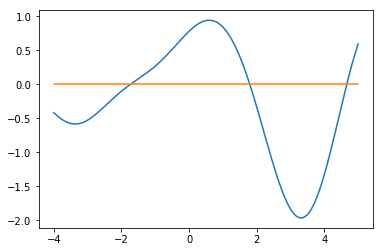

In [4]:
grad = [ m.predictive_grad(x.reshape(1,1)) for x in Xt ]
grad = np.array(grad)
fig, ax = plt.subplots()
ax.plot(Xt, grad.ravel(), label="GP deriv")
ax.plot([-4,5], [0,0], label="GP deriv")


### Likelihood Surface

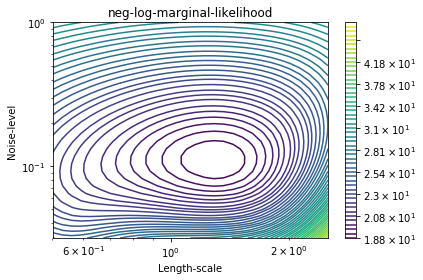

In [5]:
#### Plot LML landscape
plt.figure(1)
M = 30
theta0 = np.logspace(-0.3, 0.4,M)#np.logspace(-1, 1, M)
theta1 = np.logspace(-1.5, 0, M)#np.logspace(-2.5, 0, M)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[m.neg_log_marg_like([Theta0[i, j], Theta1[i, j]])[0]
        for i in range(M)] for j in range(M)]
LML = np.array(LML).T

vmin, vmax = (LML).min(), (LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, LML,
            levels=level, norm=colors.LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("neg-log-marginal-likelihood")
plt.tight_layout()

### likehood surface gradient

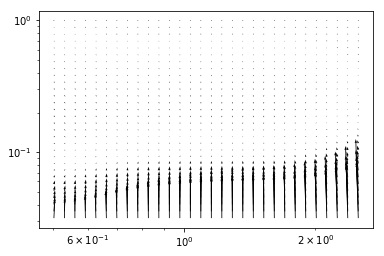

In [6]:
import sympy

# Plot LML landscape
plt.figure(1)
LML_grad = [[ m.neg_log_marg_like([Theta0[i, j], Theta1[i, j]])[1]
        for i in range(M)] for j in range(M)]
LML_grad = -np.array(LML_grad).T

plt.figure()
plt.quiver(Theta0,Theta1,LML_grad[0],LML_grad[1])
plt.xscale("log")
plt.yscale("log")
plt.show()

## 2D toy example

In [8]:
N = 100
# training data
Nt = 400
X1 = np.random.uniform(-5,5,size = (N,1)) #np.linspace(-4,5,N).reshape(N,1)
X2 = np.random.uniform(-5,5,size = (N,1))
X = np.concatenate([X1,X2],1)
# test data
Xt = np.concatenate([np.linspace(-4,5,Nt).reshape(Nt,1), np.linspace(-4,5,Nt).reshape(Nt,1)], 1)
Y = X1**2 + X2**2 + np.random.randn(N,1)*0.3


t0 = time.time()
m = mintGP()
m.fit(X,Y)
print( m.lengthscale, m.likelihood_variance )
#pred, var = m.predict(Xt,predvar=True)
t1 = time.time()
print('time to compute ',t1-t0)


[  3.46386299e+00   1.01896404e-03] [ 5.21543278  1.        ]
3.46386298728 0.00101896404276
time to compute  0.07127761840820312


In [10]:
M = 50
grid = np.linspace(-5,5,M).reshape(M,1)
XX1,XX2 = np.meshgrid(grid,grid)
Z = [[m.predict( np.array([XX1[i,j], XX2[i,j] ]).reshape(1,2) )[0,0] for i in range(M)] for j in range(M)]
Z = np.array(Z)
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(XX1, XX2, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(X1, X2, Y, c='r', s=30)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
#ax.axis('tight')

ValueError: Unknown projection '3d'

### Gradient as colorcode like in Emans sw33t pløts

In [11]:
# Color function by norm of gradient

fig = plt.figure(figsize=[8,5])
ax = fig.gca(projection='3d')

my_col = cm.jet( gradnorm / np.amax(gradnorm) )
cbar = cm.ScalarMappable(cmap=cm.jet)
cbar.set_array(my_col)
surf = ax.plot_surface(XX1, XX2, Z, rstride=2, cstride=2, alpha=0.5, facecolors = my_col, linewidth = 0 )
fig.colorbar(cbar, shrink=0.8, aspect=8)

ValueError: Unknown projection '3d'

# Tensordot experiments for gradient function to be able to take NxD arrays


In [1786]:
a = np.arange(60.).reshape(3,4,5)
b = np.arange(24.).reshape(4,3,2)
c = np.tensordot(a,b, axes=([1,0],[0,1]))
c.shape

(5, 2)

In [1787]:
c 

array([[ 4400.,  4730.],
       [ 4532.,  4874.],
       [ 4664.,  5018.],
       [ 4796.,  5162.],
       [ 4928.,  5306.]])

In [1788]:
# A slower but equivalent way of computing the same 
d = np.zeros((5,2))
for i in range(5):
    for j in range(2):
        for k in range(3):
            for n in range(4):
                d[i,j] += a[k,n,i] * b[n,k,j]
c == d

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]], dtype=bool)

In [1793]:
xnew = np.array([[4,9],[1,8]], ndmin=2)